# Can we get NUTS to work with Pyro?

NUTS is No-U-Turn-Sampling, an MCMC sampler.  Can we get it to work with Pyro?  NUTS requires Pyro, the probabilistic programming language built on PyTorch.

In [1]:
import pyro

In [2]:
pyro.__version__

'0.4.1'

We'll need some other standard and astronomy-specific imports and configurations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Make synthetic noisy data with known variance.

In [4]:
t_vec = np.linspace(0, 40, 2000)

In [5]:
a_true = 0.2
b_true = 0.3
c_true = -7
sigma_true = 10.3
known_variance = sigma_true**2

In [6]:
y_true = a_true*t_vec**2 + b_true*t_vec + c_true

In [7]:
noise = np.random.normal(0, sigma_true, size=len(y_true))
y_obs = y_true + noise

Let's get the least squares estimate.

In [8]:
A_mat = np.vander(t_vec, 3)
ATA = np.dot(A_mat.T, A_mat/known_variance)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A_mat.T, y_obs/known_variance))
lst_sq_mean_fit = np.dot(A_mat, mean_w)

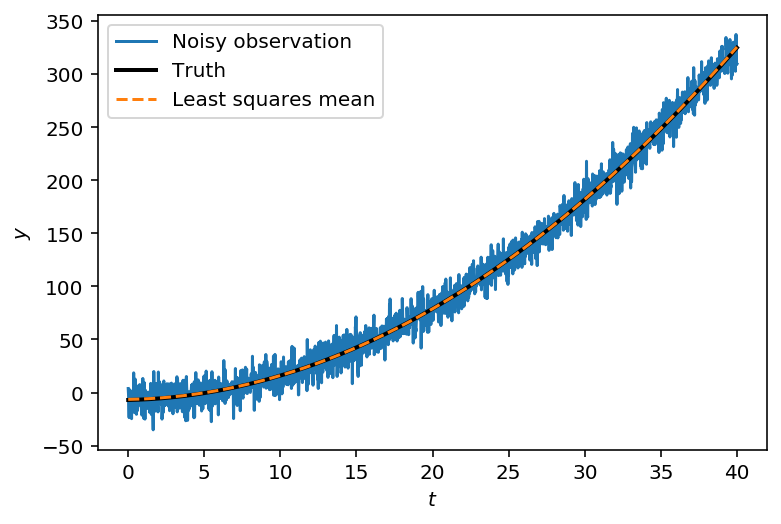

In [9]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='Truth', color='k', lw=2)
plt.plot(t_vec, lst_sq_mean_fit, label='Least squares mean', linestyle='dashed')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with!

# Pyro and HMC

In [10]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

The model is:

$y = a t^2 + b t + c$


In [11]:
def model(time_values, y_values):
    aa = pyro.sample("a", dist.Normal(0, 5000.0))
    bb = pyro.sample("b", dist.Normal(0, 5000.0))
    cc = pyro.sample("c", dist.Normal(0., 5000.0))
    mean = aa * time_values**2 + bb * time_values + cc
    #with pyro.plate("data", len(time_values)):
    pyro.sample("obs", dist.Normal(mean, sigma_true), obs=y_values)

In [12]:
nuts_kernel = NUTS(model)

In [13]:
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100)

In [14]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)

In [15]:
mcmc.run(train_x, train_y)

sample: 100%|██████████| 600/600 [00:59<00:00, 10.12it/s, step size=1.27e-02, acc. prob=0.940]


In [16]:
samples = mcmc.get_samples(group_by_chain=True)

In [17]:
truth_mapper = {'a':a_true, 'b':b_true, 'c':c_true}

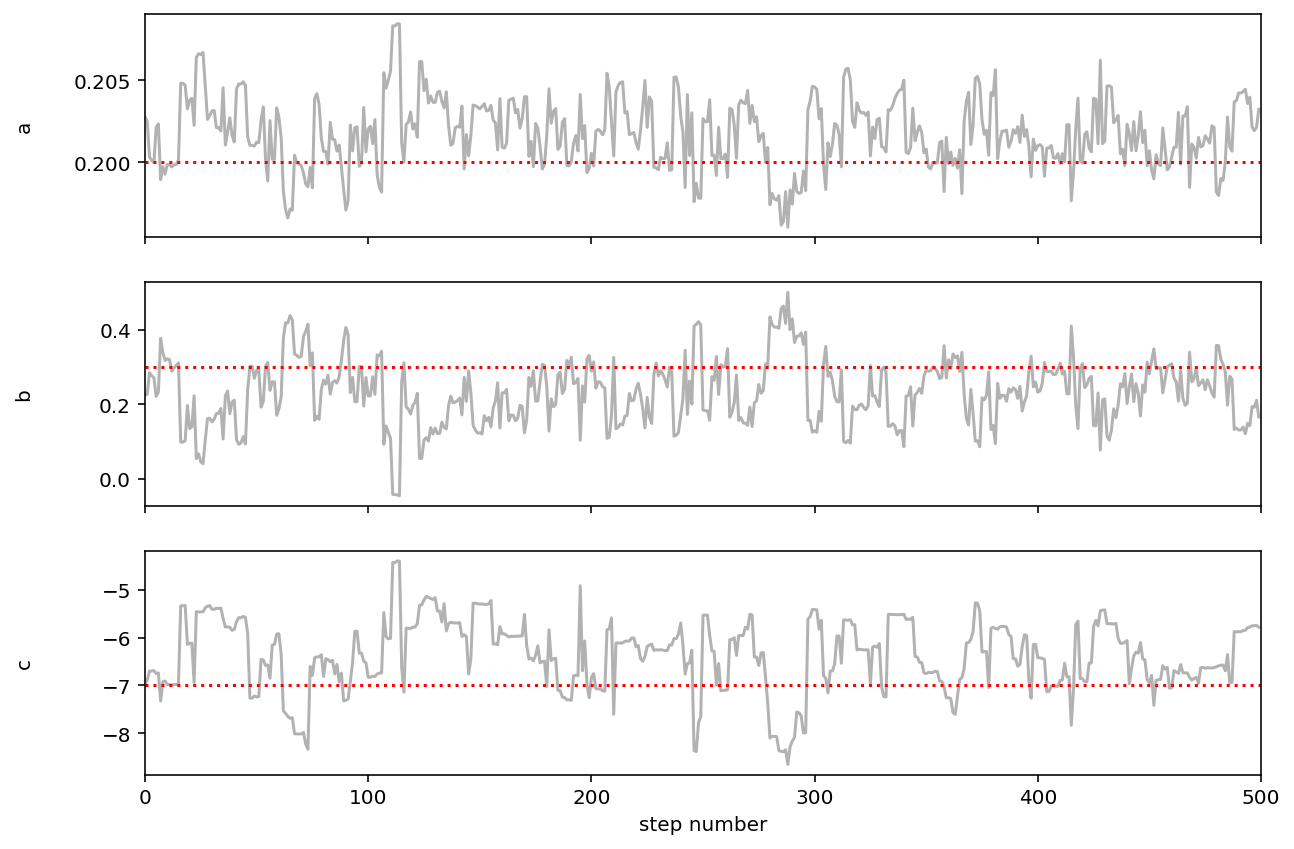

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ['a', 'b', 'c']
for i, lab in enumerate(labels):
    ax = axes[i]
    ax.plot(samples[lab], "k", alpha=0.3)
    ax.set_xlim(0, 500)
    ax.set_ylabel(lab)
    ax.axhline(truth_mapper[lab], color='r', linestyle='dotted')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Woohoo it works!  The MCMC chains were asymptotically tending towards the equilibrium answer.  The problem is that sampling with pyro was surprisingly slow.  
This performance limitation is known, and a new probabilistic programming language called `numpyro` has been developed to speed up MCMC sampling.  From the [pyro website](http://pyro.ai/):

> NumPyro Release We’re excited to announce the release of NumPyro, a NumPy-backed Pyro using JAX for automatic differentiation and JIT compilation, with over 100x speedup for HMC and NUTS!  
> See the examples and documentation for more details.

In the next tutorial we do the same experiment with numpyro!